# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [2]:
# Import packages
import os
# import sys
# from dotenv import load_dotenv
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import seaborn as sns

# Definieer data locaties
#load environment variables
input_dir = os.getenv("INPUT_DIRECTORY")
output_dir = os.getenv("OUTPUT_DIRECTORY")


## Utilities

In [3]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

def read_csv_files(directory_path):
    """
    Function to read JSON files and create DataFrame

    Args:
        directory_path (str): The path to the folder containing csv files.
    Returns:
        pandas.DataFrame: A DataFrame that contains all the data from the csv files,
                          with an extra column 'bron_datum'.
    """
    dataframes = pd.DataFrame()
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            full_path = os.path.join(directory_path, filename)
            df = pd.read_csv(full_path)
            df['bron_datum'] = filename[:-4]
            dataframes = pd.concat([dataframes, df], ignore_index=True) # Todo: remove concat
    return dataframes

def plot_geboortedagen_per_jaar(bron, horizontale_lijn):
    pl.figure(figsize=(20, 5))
    bron.plot(kind="line", color="blue", title="Aantal geboortes per dag van het jaar", label='Aantal geboortes')
    pl.axhline(horizontale_lijn, color='red', linestyle='dashed', linewidth=1, label='gemiddelde')
    pl.xlabel("Dag van het jaar")
    pl.ylabel("Aantal geboortes")
    pl.grid(axis="y")
    pl.legend()
    pl.show()

def plot_runnnig_average(df, horizontale_lijn):
    pl.figure(figsize=(20, 5))
    pl.plot(df['dag_van_het_jaar'], df['running_average'], color="blue", label='Aantal geboortes')
    pl.axhline(horizontale_lijn, color='red', linestyle='dashed', linewidth=1, label='gemiddelde')
    pl.xlabel("Dag van het jaar")
    pl.ylabel("Aantal geboortes")
    pl.grid(axis="y")
    pl.legend()
    pl.show()

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [4]:
source_data = read_csv_files(input_dir)
source_data.rename(columns={"verwachte datum": "verwachte_datum"}, inplace=True)
source_data["verwachte_datum"] = pd.to_datetime(source_data["verwachte_datum"], format="%m/%d/%Y")
source_data["bron_datum"] = pd.to_datetime(source_data["bron_datum"], format="%Y-%m-%d", errors='coerce')
source_data["dag_van_het_jaar"] = source_data["bron_datum"].dt.dayofyear
source_data['aantal_geboortes'] = source_data.groupby('bron_datum')['bron_datum'].transform('count')

df_filtered = source_data.copy()
df_wrong = source_data.copy()
df_wrong = df_wrong[df_wrong['bron_datum'].isna()]
df_filtered = source_data[~source_data['bron_datum'].isna()]
df_wrong['reden'] = 'geen schrikkeljaar'

## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

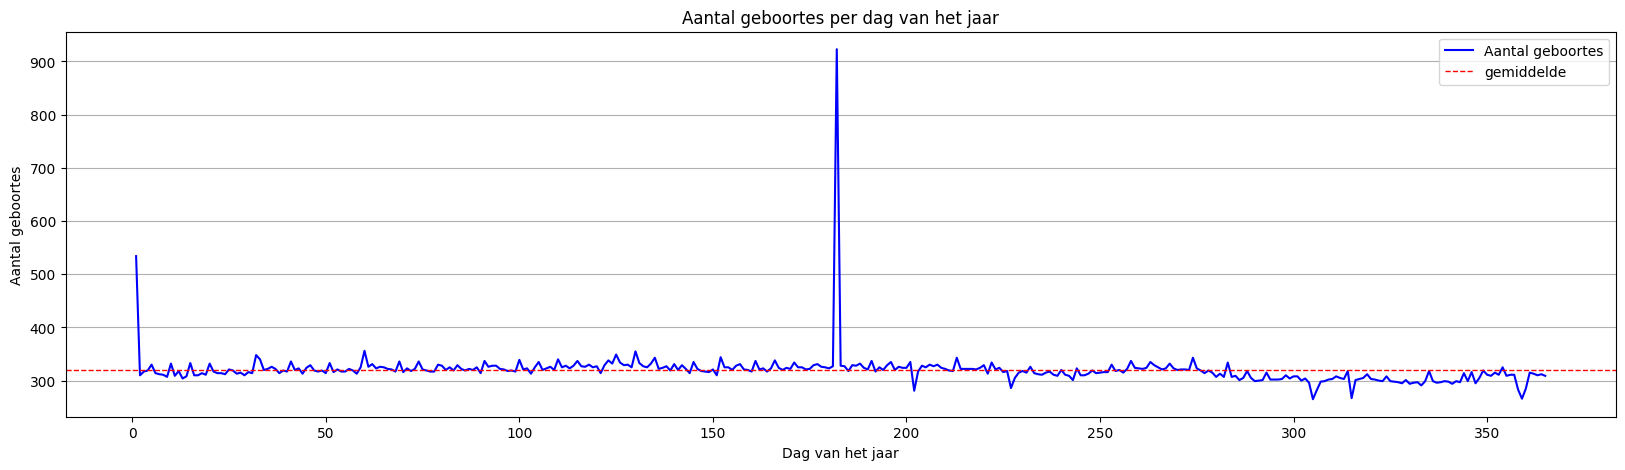

In [5]:
geboortes_per_dag_van_jaar = source_data["dag_van_het_jaar"].value_counts().sort_index()
gemiddeld_aantal_geboortes = geboortes_per_dag_van_jaar.mean()
plot_geboortedagen_per_jaar(geboortes_per_dag_van_jaar, gemiddeld_aantal_geboortes)


##

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [6]:
gemiddeld_aantal_geboortes = geboortes_per_dag_van_jaar.mean()

max_afwijking = gemiddeld_aantal_geboortes * 0.5
boven_limiet = gemiddeld_aantal_geboortes + max_afwijking
onder_limiet = gemiddeld_aantal_geboortes - max_afwijking
print(boven_limiet, onder_limiet)
outliers = source_data[(source_data['aantal_geboortes'] > boven_limiet) | (source_data['aantal_geboortes'] < onder_limiet)]['bron_datum'].unique()
display(outliers)
# # outliers = source_data["dag_van_het_jaar"].value_counts() > (gemiddeld_aantal_geboortes + max_afwijking)

480.20547945205476 160.06849315068493


<DatetimeArray>
['2019-01-01 00:00:00', '2019-07-01 00:00:00']
Length: 2, dtype: datetime64[ns]

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [7]:
te_verwijderen_dagen = ['2019-01-01', '2019-07-01']
df_incorrecte_dagen = df_filtered[df_filtered['bron_datum'].isin(te_verwijderen_dagen)]
df_filtered = df_filtered[~df_filtered['bron_datum'].isin(te_verwijderen_dagen)]
df_incorrecte_dagen['reden'] = 'datum niet correct genoteerd'
df_wrong = pd.concat([df_wrong, df_incorrecte_dagen], ignore_index=True)
display(df_wrong)

C:\Users\valen\AppData\Local\Temp\ipykernel_7176\889595781.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_incorrecte_dagen = df_filtered[df_filtered['bron_datum'].isin(te_verwijderen_dagen)]
C:\Users\valen\AppData\Local\Temp\ipykernel_7176\889595781.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_filtered = df_filtered[~df_filtered['bron_datum'].isin(te_verwijderen_dagen)]


,gemeente,naam,geslacht,verwachte_datum,bron_datum,dag_van_het_jaar,aantal_geboortes,reden
0,Kruisem,Patrick,Mannelijk,2019-02-27,NaT,NaN,NaN,geen schrikkeljaar
1,Montigny-le-Tilleul,Sarah,Vrouwelijk,2019-03-11,NaT,NaN,NaN,geen schrikkeljaar
2,Diepenbeek,Valentinus,Mannelijk,2019-03-02,NaT,NaN,NaN,geen schrikkeljaar
3,Sint-Jans-Molenbeek,El,Mannelijk,2019-02-27,NaT,NaN,NaN,geen schrikkeljaar
4,Overijse,Apolline,Vrouwelijk,2019-03-03,NaT,NaN,NaN,geen schrikkeljaar
...,...,...,...,...,...,...,...,...
1525,Oostende,Magali,Vrouwelijk,2019-07-15,2019-07-01,182.0,923.0,datum niet correct genoteerd
1526,Rotselaar,Jean,Mannelijk,2019-06-30,2019-07-01,182.0,923.0,datum niet correct genoteerd
1527,Brussel,Lina,Vrouwelijk,2019-07-11,2019-07-01,182.0,923.0,datum niet correct genoteerd
1528,Hamont-Achel,Brenda,Vrouwelijk,2019-06-25,2019-07-01,182.0,923.0,datum niet correct genoteerd


Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

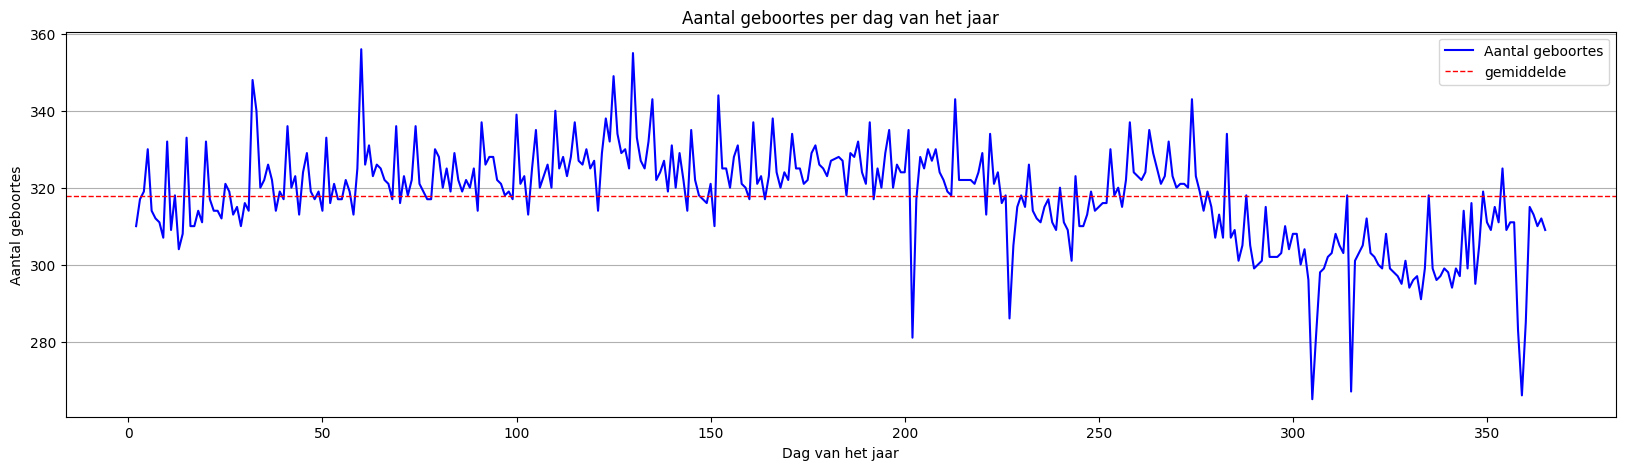

In [8]:
geboortes_per_dag_van_jaar_filtered = df_filtered["dag_van_het_jaar"].value_counts().sort_index()
gemiddeld_aantal_geboortes_filtered = geboortes_per_dag_van_jaar_filtered.mean()
plot_geboortedagen_per_jaar(geboortes_per_dag_van_jaar_filtered, gemiddeld_aantal_geboortes_filtered)

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [9]:
geboortes_per_dag_van_jaar_filtered = df_filtered["dag_van_het_jaar"].value_counts().sort_values()

filtered_df = df_filtered[df_filtered['aantal_geboortes'] < geboortes_per_dag_van_jaar_filtered.iloc[8]]
unique_bron_datum = filtered_df['bron_datum'].unique()

display(unique_bron_datum)

<DatetimeArray>
['2019-11-01 00:00:00', '2019-11-11 00:00:00', '2019-11-02 00:00:00',
 '2019-12-24 00:00:00', '2019-12-25 00:00:00', '2019-12-26 00:00:00',
 '2019-07-21 00:00:00', '2019-08-15 00:00:00']
Length: 8, dtype: datetime64[ns]

### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

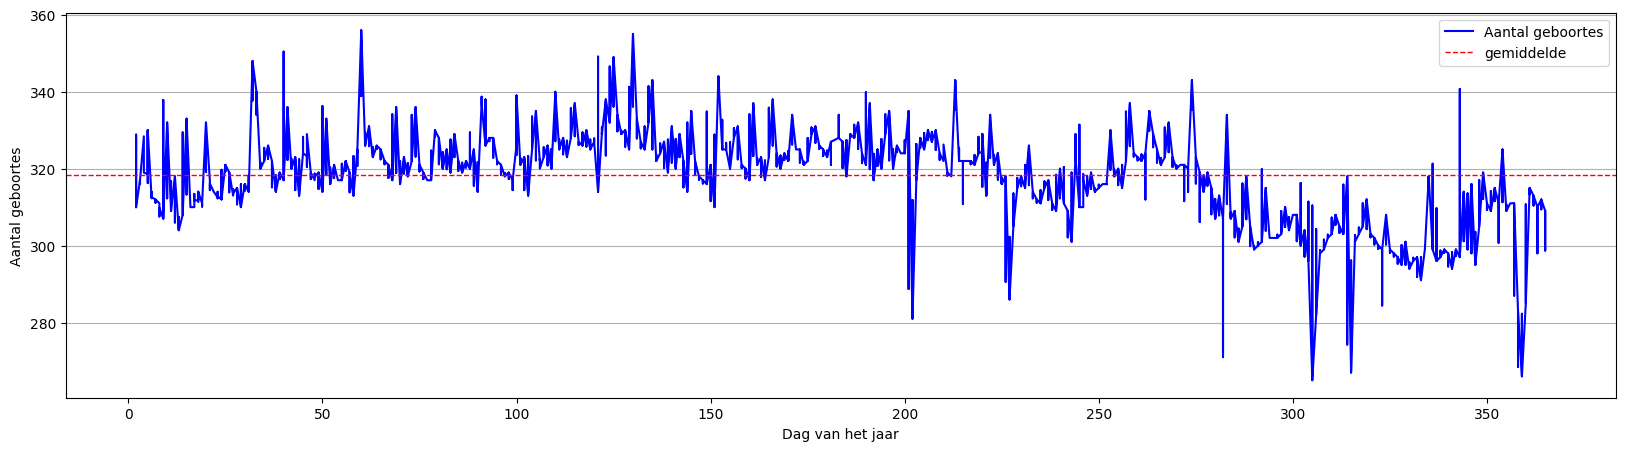

In [10]:
df_filtered["dag_van_de_week"] = df_filtered["bron_datum"].dt.weekday

running_averages = []

# Loop through each row in the dataframe
for i in range(len(df_filtered)):
    # Calculate the average of the next 7 values of 'aantal_geboortes'
    if i + 7 < len(df_filtered):
        avg_next_7 = df_filtered.iloc[i:i+7]['aantal_geboortes'].mean()
    else:
        # If there are less than 7 values remaining, calculate average of what's left
        avg_next_7 = df_filtered.iloc[i+1:]['aantal_geboortes'].mean()
    
    # Append the calculated average to the list
    running_averages.append(avg_next_7)

# Assign the list of running averages to a new column 'running_average'
df_filtered['running_average'] = running_averages
df_filtered = df_filtered.sort_values('bron_datum')
plot_runnnig_average(df_filtered, df_filtered['running_average'].mean())


Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

,gemeente,naam,geslacht,verwachte_datum,bron_datum,dag_van_het_jaar,aantal_geboortes,dag_van_de_week,running_average
3683,Namen,Sabrina,Vrouwelijk,2018-12-30,2019-01-02,2.0,310.0,2,310.0
3784,Waregem,Steven,Mannelijk,2019-01-07,2019-01-02,2.0,310.0,2,310.0
3785,Lokeren,Luc,Mannelijk,2018-12-27,2019-01-02,2.0,310.0,2,310.0
3786,Nijlen,Eric,Mannelijk,2019-01-02,2019-01-02,2.0,310.0,2,310.0
3787,Aat,Catherine,Vrouwelijk,2019-01-01,2019-01-02,2.0,310.0,2,310.0
...,...,...,...,...,...,...,...,...,...
36069,Kortrijk,Alexia,Vrouwelijk,2020-01-05,2019-12-31,365.0,309.0,1,309.0
36070,Brussel,Alexandra,Vrouwelijk,2020-01-07,2019-12-31,365.0,309.0,1,309.0
36071,Mortsel,Patrick,Mannelijk,2020-01-01,2019-12-31,365.0,309.0,1,309.0
36061,Heusden-Zolder,Wilfried,Mannelijk,2020-01-04,2019-12-31,365.0,309.0,1,309.0


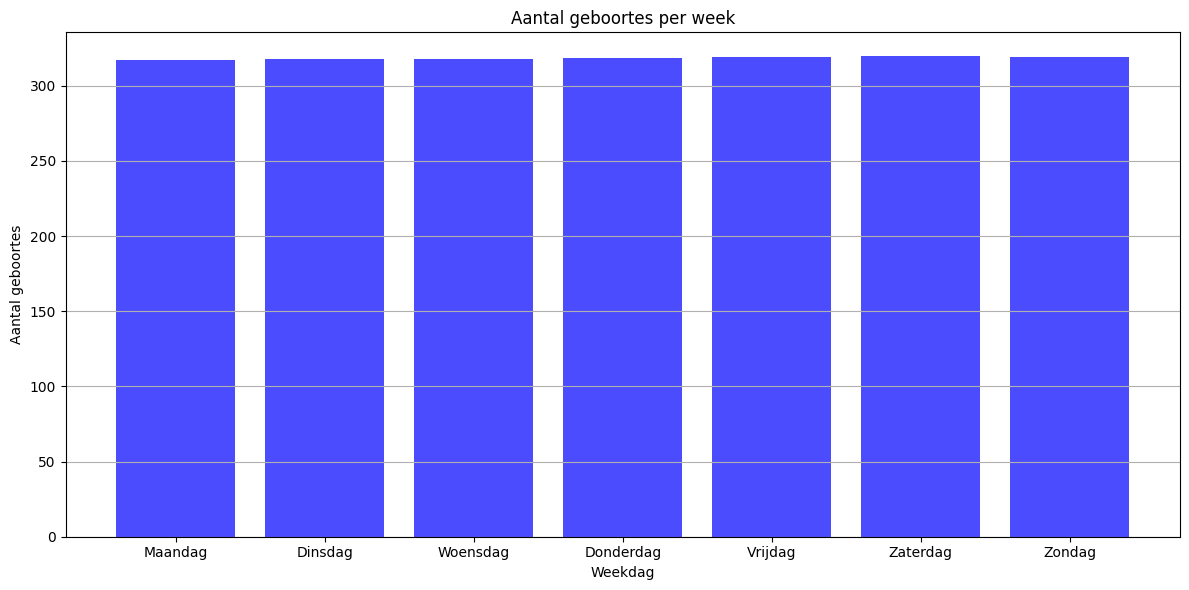

In [16]:
df_filtered["dag_van_de_week"] = df_filtered["bron_datum"].dt.weekday
display(df_filtered)
weekdagen = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']

avg_per_dag_van_de_week = df_filtered.groupby('dag_van_de_week')['aantal_geboortes'].mean()

# Plotting the bar chart of smoothed data
pl.figure(figsize=(12, 6))
pl.bar(weekdagen, avg_per_dag_van_de_week, width=0.8, color='b', alpha=0.7)
pl.title('Aantal geboortes per week')
pl.xlabel('Weekdag')
pl.ylabel('Aantal geboortes')
pl.grid(axis='y')
pl.tight_layout()
pl.show()